In [1]:
!pip install DeepXDE

In [2]:
!pip install pyarrow

In [3]:
import os
os.environ["DDE_BACKEND"] = "pytorch"

In [4]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import pandas as pd
from IPython.display import display
import torch
import pyarrow as pa
import pyarrow.orc as orc

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [5]:
x_l = -20
x_r = 20
t_lower = 0
t_upper = 0.5

x = np.linspace(x_l, x_r, 200)
t = np.linspace(t_lower, t_upper, 50)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

space_domain = dde.geometry.Interval(x_l, x_r)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)


k = 1
χ = 1
a = 0.5
x_0 = 15
θ_0 = np.pi / 3

a1 = 1
a2 = 1
a4 = 0.3
a6 = 0.1

b1 = 1

A1 = np.sqrt((2 * χ / b1) * (a2 - 6 * a4 * k ** 2 + 12 * a4 * k + 10 * a4 + 75 * a6 * k ** 4 + 150 * a6 * k ** 2 + 91 * a6))
C0 = a1 + 2 * a2 * k + 8 * a4 * k ** 3 + 96 * a6 * k ** 5
ω = a1 * k + a2 * k ** 2 - a2 + 3 * a4 * k ** 4 - 6 * a4 * k ** 2 - a4 + 35 * a6 * k ** 6 - 75 * a6 * k ** 4 - 15 * a6 * k ** 2 - a6

a3 = -4 * a4 * k - 40 * a6 * k ** 3
a5 = -6 * a6 * k

b2 = - (24 * a4 * χ ** 2 + 360 * a6 * χ ** 2 * k ** 2 + 840 * a6 * χ ** 2) / A1 ** 4
b3 = 720 * a6 * χ ** 3 / A1 ** 6

A = 0.5


def pde(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]

    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    u_xxx = dde.grad.jacobian(u_xx, x, j=0)
    v_xxx = dde.grad.jacobian(v_xx, x, j=0)

    u_xxxx = dde.grad.jacobian(u_xxx, x, j=0)
    v_xxxx = dde.grad.jacobian(v_xxx, x, j=0)

    u_xxxxx = dde.grad.jacobian(u_xxxx, x, j=0)
    v_xxxxx = dde.grad.jacobian(v_xxxx, x, j=0)

    u_xxxxxx = dde.grad.jacobian(u_xxxxx, x, j=0)
    v_xxxxxx = dde.grad.jacobian(v_xxxxx, x, j=0)

    f_u = -v_t - a1 * v_x + a2 * u_xx - a3 * v_xxx + a4 * u_xxxx - a5 * v_xxxxx + a6 * u_xxxxxx + u * (b1 * (u ** 2 + v ** 2) + b2 * (u ** 2 + v ** 2) ** 2 + b3 * (u ** 2 + v ** 2) ** 3)
    f_v = u_t + a1 * u_x + a2 * v_xx + a3 * u_xxx + a4 * v_xxxx + a5 * u_xxxxx + a6 * v_xxxxxx + v * (b1 * (u ** 2 + v ** 2) + b2 * (u ** 2 + v ** 2) ** 2 + b3 * (u ** 2 + v ** 2) ** 3)

    return [f_u, f_v]


bc_u_0 = dde.icbc.DirichletBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=0
)
bc_v_0 = dde.icbc.DirichletBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=1
)


bc_u_1 = dde.icbc.NeumannBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=0
)
bc_v_1 = dde.icbc.NeumannBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=1
)


bc_u_2 = dde.icbc.OperatorBC(
    geomtime, lambda x, u, _: dde.grad.hessian(u, x, i=0, j=0),
    lambda _, on_boundary: on_boundary
)
bc_v_2 = dde.icbc.OperatorBC(
    geomtime, lambda x, v, _: dde.grad.hessian(v, x, i=0, j=0),
    lambda _, on_boundary: on_boundary
)


def init_cond_u(x):
    exp = np.exp(np.float32(x[:, 0:1] + x_0))
    noise = A * np.random.rand(x.shape[0], 1)

    return np.cos(k * x[:, 0:1] + θ_0) * (A1 / (a * exp + χ / (4 * a * exp))) + noise


def init_cond_v(x):
    exp = np.exp(np.float32(x[:, 0:1] + x_0))

    return np.sin(k * x[:, 0:1] + θ_0) * (A1 / (a * exp + χ / (4 * a * exp)))


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)


data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_u_2, bc_v_0, bc_v_1, bc_v_2, ic_u, ic_v],
    num_domain=10000,
    num_boundary=200,
    num_initial=3000,
    train_distribution="pseudo",
)

net = dde.nn.FNN([2] + [100] * 3 + [2], "sin", "Glorot normal")

model = dde.Model(data, net)

opt = torch.optim.Adam(model.net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

model.compile(optimizer=opt, lr=0.01, loss="MSE",
              loss_weights=(1., 1., 1., 1., 1., 1., 1., 1., 5., 5.),
              decay=("inverse time", 100, 0.01143))
model.train(iterations=30000, display_every=1000, callbacks=[dde.callbacks.PDEPointResampler(period=10)])

Compiling model...
'compile' took 0.000437 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [2.09e-02, 3.92e-02, 1.81e-01, 1.76e-02, 1.10e-04, 1.01e-01, 3.08e-04, 1.10e-04, 7.32e+00, 1.36e+01]    [2.09e-02, 3.92e-02, 1.81e-01, 1.76e-02, 1.10e-04, 1.01e-01, 3.08e-04, 1.10e-04, 7.32e+00, 1.36e+01]    []  
1000      [5.97e-01, 5.05e-01, 2.99e-03, 5.54e-03, 5.30e-04, 5.77e-04, 1.12e-03, 5.30e-04, 6.40e-01, 2.63e-01]    [6.33e-01, 5.18e-01, 2.99e-03, 5.54e-03, 5.30e-04, 5.77e-04, 1.12e-03, 5.30e-04, 6.40e-01, 2.63e-01]    []  
2000      [2.56e-01, 2.80e-01, 4.58e-03, 7.34e-03, 8.65e-04, 8.01e-04, 3.28e-04, 8.65e-04, 2.21e-01, 8.09e-02]    [2.59e-01, 2.78e-01, 4.58e-03, 7.34e-03, 8.65e-04, 8.01e-04, 3.28e-04, 8.65e-04, 2.21e-01, 8.09e-02]    []  
3000      [1.02e-01, 1.10e-01, 3.44e

(<deepxde.model.LossHistory at 0x7f302370bf10>,
 <deepxde.model.TrainState at 0x7f3023704850>)

In [6]:
model.compile("L-BFGS", lr=dde.optimizers.set_LBFGS_options(maxcor=50, ftol=1.0 * np.finfo(float).eps, gtol=1e-5, maxiter=15000, maxfun=50000, maxls=25), loss="MSE")
model.train(iterations=10000, display_every=1000)

Compiling model...
'compile' took 0.000792 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
30000     [3.06e-03, 4.26e-03, 2.90e-03, 2.01e-03, 8.41e-05, 1.19e-05, 4.96e-05, 8.41e-05, 2.24e-02, 9.37e-04]    [3.14e-03, 4.49e-03, 2.90e-03, 2.01e-03, 8.41e-05, 1.19e-05, 4.96e-05, 8.41e-05, 2.24e-02, 9.37e-04]    []  
31000     [1.05e-03, 1.21e-03, 7.40e-04, 5.82e-04, 4.80e-05, 1.35e-05, 4.84e-05, 4.80e-05, 2.42e-02, 9.96e-04]    [1.41e-03, 1.59e-03, 7.40e-04, 5.82e-04, 4.80e-05, 1.35e-05, 4.84e-05, 4.80e-05, 2.42e-02, 9.96e-04]    []  
32000     [7.22e-04, 8.54e-04, 7.12e-04, 4.90e-04, 2.71e-05, 1.26e-05, 4.87e-05, 2.71e-05, 2.39e-02, 8.63e-04]    [9.54e-04, 1.13e-03, 7.12e-04, 4.90e-04, 2.71e-05, 1.26e-05, 4.87e-05, 2.71e-05, 2.39e-02, 8.63e-04]    []  
33000     [5.37e-04, 6.83e-04, 6.92e

(<deepxde.model.LossHistory at 0x7f302370bf10>,
 <deepxde.model.TrainState at 0x7f3023704850>)

In [7]:
prediction = model.predict(X_star)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

q = np.sqrt(u ** 2 + v ** 2)

def u_exact(x, t):
    return np.cos(k * x - ω * t + θ_0) * (A1 / (a * np.exp(x - C0 * t + x_0) + χ * np.exp(-(x - C0 * t + x_0)) / (4 * a)))


def v_exact(x, t):
    return np.sin(k * x - ω * t + θ_0) * (A1 / (a * np.exp(x - C0 * t + x_0) + χ * np.exp(-(x - C0 * t + x_0)) / (4 * a)))


def q_exact(x, t):
    return A1 / (a * np.exp(x - C0 * t + x_0) + χ * np.exp(-(x - C0 * t + x_0)) / (4 * a))


data_ = {'x': X.flatten(), 't': T.flatten(), 'pred_u': u.flatten(), 'pred_v': v.flatten(), 'pred_h': q.flatten(),
        'true_u': u_exact(X, T).flatten(), 'true_v': v_exact(X, T).flatten(), 'true_h': q_exact(X, T).flatten()
         }

df = pd.DataFrame(data_)
table = pa.Table.from_pandas(df)
orc.write_table(table, 'my_data_noise_.orc')
display(df)

,x,t,pred_u,pred_v,pred_h,true_u,true_v,true_h
0,-20.000000,0.0,0.098505,-0.008918,0.098908,1.159230e-01,-1.201136e-02,1.165437e-01
1,-19.798995,0.0,0.114620,-0.002907,0.114656,1.418064e-01,1.390711e-02,1.424867e-01
2,-19.597990,0.0,0.145463,0.022806,0.147240,1.664858e-01,5.127462e-02,1.742028e-01
3,-19.396985,0.0,0.197408,0.071276,0.209881,1.869268e-01,1.020624e-01,2.129750e-01
4,-19.195980,0.0,0.265139,0.145601,0.302487,1.990124e-01,1.678892e-01,2.603703e-01
...,...,...,...,...,...,...,...,...
9995,19.195980,0.5,0.068711,-0.101941,0.122936,-1.791713e-11,-4.025462e-11,4.406198e-11
9996,19.396985,0.5,0.024584,-0.073472,0.077476,-7.785989e-12,-3.518755e-11,3.603866e-11
9997,19.597990,0.5,-0.002640,-0.040668,0.040754,-4.939234e-13,-2.947218e-11,2.947632e-11
9998,19.798995,0.5,-0.013264,-0.014231,0.019454,4.416923e-12,-2.370087e-11,2.410893e-11


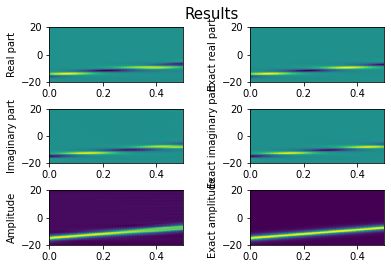

In [8]:
fig, ax = plt.subplots(3, 2)

plt.suptitle("Results", fontsize=15, x=0.5, y=0.95)

ax[0, 0].set_ylabel("Real part")
ax[0, 0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[1, 0].set_ylabel("Imaginary part")
ax[1, 0].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[2, 0].set_ylabel("Amplitude")
ax[2, 0].imshow(
    q.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)

ax[0, 1].set_ylabel("Exact real part")
ax[0, 1].imshow(
    u_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[1, 1].set_ylabel("Exact imaginary part")
ax[1, 1].imshow(
    v_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[2, 1].set_ylabel("Exact amplitude")
ax[2, 1].imshow(
    q_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

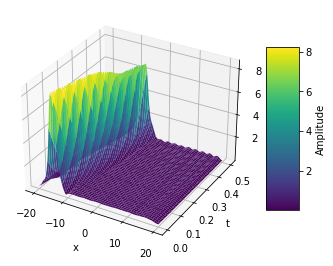

In [9]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')

surf = ax.plot_surface(X, T, q, cmap='viridis', edgecolor='none')

cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Amplitude')

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('Amplitude')

plt.show()

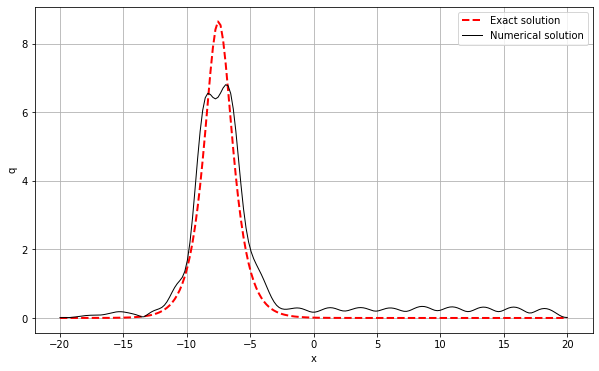

In [10]:
q_exact_values = q_exact(x, t_upper)

plt.figure(figsize=(10, 6))
plt.plot(x, q_exact_values, 'r--', label='Exact solution', linewidth=2)
plt.plot(x, q[-1, :], 'k-', label='Numerical solution', linewidth=1)
plt.xlabel('x')
plt.ylabel('q')
plt.legend()
plt.grid()
plt.show()